<hr style="border:2px solid coral"></hr>

# Homework #6 (solutions)

<hr style="border:2px solid coral"></hr>

* <a href="#prob1"> Problem #1</a> CG with general boundary conditions discretized on nodes. 


* <a href="#prob2"> Problem #2</a> Serial CG with general boundary conditions discretized on cell-centered mesh


* <a href="#prob3"> Problem #3</a> Parallel CG on mesh of your choice 


* <a href="#prob4"> Problem #2</a> 2d CG on mesh of your choice




<a id="prob1"></a>

<hr style="border:2px solid coral"></hr>

# Problem #1

<hr style="border:2px solid coral"></hr>

The following serial code solves the problem

\begin{equation}
u''(x) = e^{-x^2}, \quad x \in [a,b]
\end{equation}

subject to $u(a) = u(b) = 0$.   At $a=0$ and $b=1$, the solution should satisfy the true solution

\begin{equation}
u_{true}(x) = \frac{1}{2}\left[\sqrt{\pi}\; x \;\mbox{erf}(x) + e^{-x^2}\right]
\end{equation}

The goal of this problem is to impose general, *nonhomogeneous* Dirichlet and Neumann boundary conditions at both $x=a$ and $x=b$. 

Possible combinations of boundary conditions are

* Dirichlet conditions at both ends

* Neumann conditions at the left end and Dirichlet at the right end. 

* Dirichlet condition at the left end and Neumann at the right end. 


### To do 

The code below implements homogeneous Dirichlet conditions at endpoints of the interval $[a,b]$.  


* Modify the code below so that general Dirichlet and Neumann boundary conditions are correctly imposed. 

  Define the mesh $x_j = a + jh$ for $j = 0,1,\dots N$ and $h = (b-a)/N$.  
  
  
<center>
<img width=550 style="padding:20px" src="./mesh_01.png"></img>    
</center>   
  

   * **Dirichlet conditions.** Solve only at interior nodes and impose the solution 
   
   \begin{equation}
   u_0 = u_{true}(a), \quad u_N = u_{true}(b)
   \end{equation}

   at boundary nodes.

   * **Neumann condition.** For the Neumann condition at $x=b$, we can set a ghost cell value in $u_{N+1}$ using the equation

   \begin{equation}
   \frac{u_{N+1} - u_{N-1}}{2h} = u'(b) \quad \Longrightarrow \quad u_{N+1} = 2hu'(b) + u_{N-1} 
   \end{equation}

   At the left boundary, it is conventional to impose the condition
  
   \begin{equation}
   \frac{u_{-1} - u_{1}}{2h} = -u'(a) \quad \Longrightarrow \quad u_{-1} = -2hu'(a) + u_{1} 
   \end{equation}

   For this problem, you can use $u'(x) = \sqrt{\pi}\;\mbox{erf}(x)/2$.   See the Sympy calculation below.

  You should be able to switch between the Dirichlet and Neumann cases with a command line switch, i.e. 
  
        % cg_serial_01 <N> <bc_type_left> <bc_type_right>
        
  For example, 
  
        % cg_serial_01 8 0 0    # N = 8, bc_type is Dirichlet at both ends
        % cg_serial_01 16 1 0   # N = 16, bc_type is Neumann at the left edge
        % cg_serial_01 32 0 1   # N = 32, bc_type is Neumann at the right edge

* Your code should show second order accuracy for the all three cases above. 

### Tips

* You don't need to adjust the sizes of any arrays for this problem, but you will need to specify starting and stopping locations for the computation of the matrix-vector multiply, calculation of the dot products, array updates, and the error computation.  For example, for the all-Dirichlet case, the matrix-vector multiply loop should start at $j=1$ and end at $j=N-1$.  
  
  
  
* For the Neumann condition at one endpoint, you will need to modify the equation at that endpoint so that you recover a symmetric linear system.  What is a trick for doing this? 


* You can use these convergence results to verify your code.   Your results should be essentially identical to these results. 

        Serial results (node-centered mesh)
        a=0.000000 b=1.000000
        Left  : bc_types.NEUMANN
        Right : bc_types.DIRICHLET

            8   8.2587e-04        8      ---
           16   2.0594e-04       16   4.0102   2.0037
           32   5.1453e-05       32   4.0025   2.0009
           64   1.2861e-05       64   4.0006   2.0002
          128   3.2152e-06      128   4.0002   2.0001
          256   8.0379e-07      256   4.0000   2.0000
          512   2.0095e-07      512   4.0000   2.0000
         1024   5.0237e-08     1024   4.0000   2.0000    

In [1]:
import sys
sys.version

'3.9.12 (main, Apr  5 2022, 01:53:17) \n[Clang 12.0.0 ]'

In [2]:
import sympy as sp

x = sp.symbols('x')

u = (sp.sqrt(sp.pi)*x*sp.erf(x) + sp.exp(-x*x))/2;
dfdx = u.diff(x,1).simplify()

print("u'(x) = ")
display(dfdx)

u'(x) = 


sqrt(pi)*erf(x)/2

In [3]:
%reset -f

In [4]:
from matplotlib.pyplot import *
from numpy import *

In [5]:
%%file hmwk06_all_1d.c

enum 
{
    DIRICHLET = 0,
    NEUMANN,
};

enum
{
    LEFT=0,
    RIGHT
};

double* allocate_1d(int n, int m)
{
    double *mem = (double*) malloc((n + 2*m)*sizeof(double));
    return mem+m;
}

void free_1d(double **x, int m)
{
    free(*x-m);
    *x = NULL;
}

int parse_input(int argc, char** argv, int* N, int* bc_type)
{
    if (argc != 4)
    {
        *N = 64;
        bc_type[LEFT] = bc_type[RIGHT] = DIRICHLET;
    }
    else
    {
        *N = atoi(argv[1]);
        bc_type[LEFT] = atoi(argv[2]);
        bc_type[RIGHT] = atoi(argv[3]);
    }
    return 0;
}    


double u_true(double x)
{
    return (sqrt(M_PI)*x*erf(x) + exp(-x*x))/2.0;
}

double up_true(int iside, double x)
{
    double ux = sqrt(M_PI)*erf(x)/2.0;
    if (iside == LEFT)
        return -ux;
    else
        return ux;
}

double upp_true(double x)
{
    return exp(-x*x);
}

Overwriting hmwk06_all_1d.c


In [6]:
%%file cg_serial_01.c

#include <stdio.h>
#include <stdlib.h>
#include <math.h>

#include "hmwk06_all_1d.c"

static int bc_type[2];

void matvec(int N, double *u, double *L)
{
    // # TODO : Set ghost cell values for general Dirichlet and Neumann conditions
    int i1 = 1, i2 = N;
    
    if (bc_type[LEFT] == NEUMANN)
    {
      i1 = 0; 
     u[-1] = u[1];
     
    }
        
    else
    {
      i1 = 1; 
      u[0] =0;
    }
      
    if (bc_type[RIGHT] == NEUMANN)
    {
        i2 = N + 1; 
        u[N+1] = u[N-1];
    }
       
    else
        u[N] =0;
        
    
    for(int i = i1; i < i2; i++) 
    {
        
            L[i] = u[i-1] - 2*u[i] + u[i+1];
    }
            
    if (bc_type[LEFT] == NEUMANN)
    
            L[0] *= 0.5; 
            
    if(bc_type[RIGHT] == NEUMANN)
            L[N] *= 0.5;
}

int cg(int N, double *F, double *u, double tol, int kmax, int prt)
{
    // # TODO : Check that loop start and stop indices are correct for general boundary
    // # conditions.
    
    double *uk = allocate_1d(N+1,0);
    double *pk = allocate_1d(N+1,1);
    
    double *rk = allocate_1d(N+1,0);
    int i1 =1, i2=N;
    
    if (bc_type[LEFT] == NEUMANN)
    {
      i1 = 0; 
 
    }
    if (bc_type[RIGHT] == NEUMANN)
    {
      i2 = N+1; 
 
    }
    for(int i = i1; i < i2; i++)
    {
        uk[i] = 0;
        rk[i] = F[i];
        pk[i] = rk[i];    // # Start with uk = 0 --> r = b - Au = b            
    }
    
    double *Apk = allocate_1d(N+1,0);
    double *rkp1 = allocate_1d(N+1,0);
    
    int itcount = 0;
    for(int k = 0; k < kmax; k++)
    {        
        matvec(N,pk,Apk);
        
        double rTr = 0;
        double pTAp = 0;
        for(int i = i1; i < i2; i++)
        {
            rTr += rk[i]*rk[i];
            pTAp += pk[i]*Apk[i];
        }
        if (pTAp == 0)
        {
            printf("pTAp == 0; returning solution\n");
            break;
        }
        double alpha = rTr/pTAp;
        
        double rpTrp = 0;
        double max_res = 0;
        for(int i = i1; i < i2; i++)
        {
            uk[i] = uk[i] + alpha*pk[i];
            rkp1[i] = rk[i] - alpha*Apk[i];
            rpTrp += rkp1[i]*rkp1[i];
            max_res = fmax(fabs(rkp1[i]),max_res);
        }

        itcount = k+1;
        if (prt)
            printf("%5d %12.4e\n",itcount,max_res);
        
        if (max_res < tol)
            break;
                
        double beta = rpTrp/rTr;
        
        // # Update search directions
        for(int i = i1; i < i2; i++)
            pk[i] = rkp1[i] + beta*pk[i];
                
        // # Update values
        for(int i = i1; i < i2; i++)
            rk[i] = rkp1[i];
        
        rTr = rpTrp;
            
    }
    for(int i = i1; i < i2; i++)
        u[i] = uk[i];    
    
    free_1d(&uk,0);
    free_1d(&pk,1);
    free_1d(&Apk,0);
    free_1d(&rk,0);
    free_1d(&rkp1,0);
        
    return itcount;
}

int main(int argc, char** argv)
{
    int N;
    int code = parse_input(argc,argv,&N,&bc_type[0]);
    if (code > 0)
        exit(1);    

    // # Domain
    double a = 0, b = 1;
    
    // # Numerical parameters
    int kmax;
    if (bc_type[LEFT] == NEUMANN && bc_type[RIGHT] == NEUMANN)
    {
        kmax = 30;
        printf("All Neumann boundary conditions may not converge. " \
               "Value of kmax is set to %d.\n\n",kmax);
    }
    else
        kmax = 5000;
    
    double tol = 1e-12;
    
    // # 0: Don't report iterates;  1=Report iterates
    int prt = 0;

    // # Arrays    
    double *u = allocate_1d(N+1,0);
    double *F = allocate_1d(N+1,0);
    double *x = allocate_1d(N+1,0);
    
    // # Set up right hand side F
    double h = (b-a)/N;    
    for(int i = 0; i < N+1; i++)
    {
        x[i] = a + i*h;
        F[i] = h*h*upp_true(x[i]);        
    }

    if (bc_type[LEFT] == DIRICHLET)
        F[1] -= u_true(a);
    else if (bc_type[LEFT] == NEUMANN)
        F[0] = 0.5*(F[0] - 2*h*up_true(LEFT,a));
    
    if (bc_type[RIGHT] == DIRICHLET)
        F[N-1] -= u_true(b);   
   
    else if (bc_type[RIGHT] == NEUMANN)
        F[N] = 0.5*(F[N] - 2*h*up_true(RIGHT,b));
     
    
    // # Compute the solution using CG
    int itcount = cg(N,F,u,tol,kmax,prt);

    // # Supply known boundary conditions
    if (bc_type[LEFT] == DIRICHLET)
        u[0] = u_true(a);

    if (bc_type[RIGHT] == DIRICHLET)
        u[N] = u_true(b);
    
    double max_err = 0;
    for(int i = 0; i < N+1; i++)
        max_err = fmax(fabs(u_true(x[i]) - u[i]),max_err);
    
    printf("\n");
    printf("N = %d\n",N);
    printf("Iteration count : %12d\n",itcount);
    printf("Error (pde)     : %12.4e\n",max_err);        
    
    FILE* fout = fopen("err_01.dat","wb");   
    fwrite(&max_err,sizeof(double),1,fout);
    fwrite(&itcount,sizeof(int),1,fout);
    fclose(fout);    
    
    fout = fopen("cg_01.dat","wb");   
    fwrite(&N,sizeof(int),1,fout);    
    fwrite(bc_type,sizeof(int),2,fout);
    fwrite(&a,sizeof(double),1,fout);
    fwrite(&b,sizeof(double),1,fout);
    fwrite(&x[0],sizeof(double),N+1, fout); 
    fwrite(&u[0],sizeof(double),N+1, fout);             
    fclose(fout);

    free_1d(&u,0);
    free_1d(&F,0);
    free_1d(&x,0);
    return 0;
}    

Overwriting cg_serial_01.c


### (prob1) Run code and get output

In [7]:
%%bash

rm -rf cg_01.dat

rm -rf cg_serial_01.o cg_serial_01

gcc -o cg_serial_01 cg_serial_01.c
 
./cg_serial_01 32 1 0 


N = 32
Iteration count :           32
Error (pde)     :   5.1453e-05


In [8]:
import os

fout = open("cg_01.dat","rb")
N, = fromfile(fout,dtype=int32,count=1)
fout.close()

stats = os.stat("cg_01.dat")
print(f"File size          : {stats.st_size:d} bytes")

esize = 3*4 + 8*(2 + 2*(N+1))
print(f"Expected file size : {esize:d} bytes")

File size          : 556 bytes
Expected file size : 556 bytes


In [9]:
from enum import Enum

In [10]:
dt = dtype([('N',int32),\
            ('bc_type',int32,2), \
            ('a',float64), \
            ('b',float64),\
            ('x',float64,N+1), \
            ('u',float64,N+1)])

fout = open("cg_01.dat","rb")
N,bc,a,b,x,u = fromfile(fout,dtype=dt, count=1)[0]
fout.close()

bc_types = Enum('bc_types', ['DIRICHLET', 'NEUMANN'], start = 0)
bc_type = [bc_types(bc[i]) for i in [0,1]]

print(f"{N=:d} {a=:f} {b=:f}")
print(f"Left  : {bc_type[0]:s}")
print(f"Right : {bc_type[1]:s}")

N=32 a=0.000000 b=1.000000
Left  : bc_types.NEUMANN
Right : bc_types.DIRICHLET


### (prob1) Plot the solution

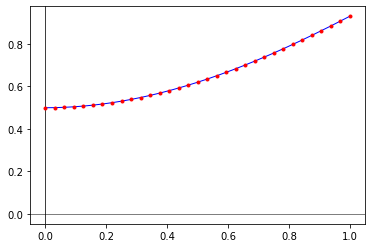

In [11]:
import scipy
from scipy.special import erf

figure(2)
clf()

# Plot axes
kwargs = {'color' : 'k', 'lw' : 0.5, 'ls' : '-'}
axhline(**kwargs)
axvline(**kwargs)
axvline(**kwargs);

def u_true(x):
    return (sqrt(pi)*x*erf(x) + exp(-x*x))/2     

xf = linspace(a,b,128)
plot(xf,u_true(xf),'b-',lw=1,label='True solution');

plot(x,u,'ro',ms=3,label='Computed solution');



In [12]:
# Leave blank

### (prob1) Convergence

Your convergence results should match these results below.

        Serial results (node-centered mesh)
        a=0.000000 b=1.000000
        Left  : bc_types.NEUMANN
        Right : bc_types.DIRICHLET

            8   8.2587e-04        8      ---
           16   2.0594e-04       16   4.0102   2.0037
           32   5.1453e-05       32   4.0025   2.0009
           64   1.2861e-05       64   4.0006   2.0002
          128   3.2152e-06      128   4.0002   2.0001
          256   8.0379e-07      256   4.0000   2.0000
          512   2.0095e-07      512   4.0000   2.0000
         1024   5.0237e-08     1024   4.0000   2.0000    

In [13]:
import subprocess
import shlex

print("Serial results (node-centered mesh)")
print(f"{a=:f} {b=:f}")
print(f"Left  : {bc_type[0]:s}")
print(f"Right : {bc_type[1]:s}",end="\n\n")

bc_str = ' '.join([f"{bc_type[i].value:d}" for i in range(2)])
shell_cmd = './cg_serial_01 {N:d} {bc_str:s}'.format

M = 8
N0 = 8
Nv = N0*2**arange(M)

dt1 = dtype([('err',float64),('itcount',int32)])

err = empty(M)
for i in range(M):
    N = Nv[i]
    cmd = shell_cmd(N=N,bc_str=bc_str)
    arg_list = shlex.split(cmd) 

    # Run output
    output = subprocess.run(arg_list,capture_output=True)
    if rc := output.returncode != 0:
        print(f"Return code = {rc:d} : Invalid boundary condition choice")
        break
        
    fout = open("err_01.dat","rb")
    err_pde,itcount = fromfile(fout,dtype=dt1, count=1)[0]
    fout.close()
        
    err[i] = err_pde
    
    print(f"{N:5d} {err_pde:12.4e} {itcount:8d} ",end="")    
    if i > 0:
        rate2 = (err[i-1]/err[i])
        print(f"{rate2:8.4f} {log2(rate2):8.4f}")
    else:
        print("{:>8s}".format("---"))

Serial results (node-centered mesh)
a=0.000000 b=1.000000
Left  : bc_types.NEUMANN
Right : bc_types.DIRICHLET

    8   8.2587e-04        8      ---
   16   2.0594e-04       16   4.0102   2.0037
   32   5.1453e-05       32   4.0025   2.0009
   64   1.2861e-05       64   4.0006   2.0002
  128   3.2152e-06      128   4.0002   2.0001
  256   8.0379e-07      256   4.0000   2.0000
  512   2.0095e-07      512   4.0000   2.0000
 1024   5.0236e-08     1024   4.0000   2.0000


In [14]:
# Leave blank

<a id="prob2"></a>

<hr style="border:2px coral solid"></hr>

## Problem #2 : Cell centered

<hr style="border:2px coral solid"></hr>

For this problem you will solve the elliptic problem from Problem #1.  

For Problem #2, however, you will solve on a *cell-centered* mesh $x_j = a + (j+0.5)h$. 
<center>
<img width=550 style="padding:20px" src="./mesh_02.png"></img>    
</center>   

Unknown values $u_j$, $j=0,1,\dots,N-1$ are located at the centers of each mesh cell.  Ghost cells values are located at $x_{-1}$ and $x_{N}$. 

### To Do 

*   Define the mesh $x_j = a + (j+1/2)h$ for $j = 0,1,\dots N-1$ and $h = (b-a)/N$.  

* Modify the code from Problem #1 to solve the elliptic problem with user-defined boundary conditions as in Problem #1.  

* Plot the solution for a $64 \times 64$ grid and show that you get second order accuracy for the problem with a Neumann condition the left boundary and a Dirichlet condition at the right boundary.

### Tips

   * Since the cell-centered nodes are not located at $x=a$ or $x=b$, we are not able to impose either Dirichlet or Neumann boundary conditions exactly.

   * **Dirichlet conditions.** The boundary at $x_{-1/2}=a$ falls halfway between nodes $x_{-1}$ and $x_0$ and so we impose a Dirichlet condition by averaging values $u_{-1}$ and $u_0$ to get  a value for the ghost cell $u_{-1}$ as 
   
   \begin{equation}
   \frac{u_{-1} + u_0}{2} = u(a) \quad \Longrightarrow \quad u_{-1} = 2 u(a) - u_0
   \end{equation}

  An analogous formula for a Dirichlet condition at $x_{N-1/2}=b$ is given by

   \begin{equation}
   \frac{u_{N-1} + u_N}{2} = u(b) \quad \Longrightarrow \quad u_{N} = 2 u(b) - u_{N-1}
   \end{equation}

   * **Neumann condition.** Unlike the node centered mesh in Problem #1, we do not need to increase the number of unknowns in order to a impose Neumann condition.  Using the same idea as above, we have at $x_{-1/2} = a$

   \begin{equation}
   \frac{u_{-1} - u_{0}}{h} = -u'(a) \quad \Longrightarrow \quad u_{-1} = -hu'(a) + u_{0} 
   \end{equation}

   At the right boundary $x_{N-1/2} = b$, we have
  
   \begin{equation}
   \frac{u_{N} - u_{N-1}}{h} = u'(b) \quad \Longrightarrow \quad u_{N} = hu'(b) + u_{N-1} 
   \end{equation}

   For this problem, you can use $u'(x) = \sqrt{\pi}\;\mbox{erf}(x)/2$.   See the Sympy calculation below.

* Use these results to verify that your code is working. 




### Question 

* Discuss which approach is easier, the node centered, or cell-centered.  Which method is easier for applying general boundary conditions?  Which code is shorter? 

In [15]:
# Leave blank

In [16]:
%%file cg_serial_02.c

#include <stdio.h>
#include <stdlib.h>
#include <math.h>

#include "hmwk06_all_1d.c"

int bc_type[2];
void matvec(int N, double *u, double *L)
{
    // # TODO : Generalize boundary condtions. 
    int i1 =0;
    int i2 = N;
     
    u[-1] = ( bc_type[LEFT] == NEUMANN)? u[0]:-u[0];
    u[N] = (bc_type[RIGHT] == NEUMANN)? u[N-1]: -u[N-1];
    
    for(int i = i1; i < i2; i++)
    {
      L[i] = u[i-1] - 2*u[i] + u[i+1];
    }
  
}

int cg(int N, double *F, double *u, double tol, int kmax, int prt)
{
    
    // # TODO : Check start and stop indices. 
    
    int i1 = 0;
    int i2 = N;
    
    double *uk = allocate_1d(N,0);
    double *pk = allocate_1d(N,1);    
    double *rk = allocate_1d(N,0);
    double *Apk = allocate_1d(N,0);
    double *rkp1 = allocate_1d(N,0);
    
    
    for(int i = i1; i < i2; i++)
    {
        uk[i] = 0;
        rk[i] = F[i];
        pk[i] = rk[i];    // # Start with uk = 0 --> r = b - Au = b            
    }
    
    int itcount = 0;
    for(int k = 0; k < kmax; k++)
    {        
        matvec(N,pk,Apk);
        
        double rTr = 0;
        double pTAp = 0;
        for(int i = i1; i < i2; i++)
        {
            rTr += rk[i]*rk[i];
            pTAp += pk[i]*Apk[i];
        }
        if (pTAp == 0)
        {
            printf("pTAp == 0; returning solution\n");
            break;
        }
        double alpha = rTr/pTAp;
        
        double rpTrp = 0;
        double max_res = 0;
        for(int i = i1; i < i2; i++)
        {
            uk[i] = uk[i] + alpha*pk[i];
            rkp1[i] = rk[i] - alpha*Apk[i];
            rpTrp += rkp1[i]*rkp1[i];
            max_res = fmax(fabs(rkp1[i]),max_res);
        }

        itcount = k+1;
        if (prt)
            printf("%5d %12.4e\n",itcount,max_res);
        
        if (max_res < tol)
            break;
                
        double beta = rpTrp/rTr;
        
        // # Update search directions
        for(int i = i1; i < i2; i++)
            pk[i] = rkp1[i] + beta*pk[i];
                
        // # Update residuals
        for(int i = i1; i < i2; i++)
            rk[i] = rkp1[i];
        
        rTr = rpTrp;
            
    }
    for(int i = i1; i < i2; i++)
        u[i] = uk[i];    
    
    free_1d(&uk,0);
    free_1d(&pk,1);
    free_1d(&rk,0);
    free_1d(&Apk,0);
    free_1d(&rkp1,0);
        
    return itcount;
}

int main(int argc, char** argv)
{

    int N;
    int code = parse_input(argc,argv,&N,&bc_type[0]);
    if (code > 0)
        exit(1);
    
    // # Domain
    double a = 0, b = 1;
    
    // # Numerical parameters
    int kmax;
    if (bc_type[LEFT] == NEUMANN && bc_type[RIGHT] == NEUMANN)
    {
        kmax = 30;
        printf("All Neumann boundary conditions may not converge. " \
               "Value of kmax is set to %d.\n\n",kmax);
    }
    else
        kmax = 100000;
        
    double tol = 1e-12;
    int prt = 0;

    double h = (b-a)/N;
    
    // # Arrays    
    double *u = allocate_1d(N,1);
    double *F = allocate_1d(N,0);
    double *x = allocate_1d(N,0);
    
    // # Initialization
    for(int i = 0; i < N; i++)
    {
        x[i] = a + (i+0.5)*h;
        F[i] = h*h*upp_true(x[i]);        
    }

    // # TODO : Modify right hand side to account for inhomogeneous BCs
    
    if (bc_type[LEFT] == DIRICHLET)
        F[0] -=2*u_true(a);
    
    if (bc_type[RIGHT] == DIRICHLET)
        F[N-1] -=2*u_true(b);
    
    if (bc_type[LEFT] == NEUMANN)
        F[0] -=h*up_true(LEFT,a);
    
    if (bc_type[RIGHT] == NEUMANN)
        F[N-1] -=h*up_true(RIGHT,b);
    
    
    // # Compute the solution using conjugate Gradient method
    int itcount = cg(N,F,u,tol,kmax,prt);
            
    // # Compute error 
    double max_err = 0;
    for(int i = 0; i < N; i++)
        max_err = fmax(fabs(u_true(x[i]) - u[i]),max_err);
    
    // # Print out results
    printf("\n");
    printf("N = %d\n",N);
    printf("Iteration count : %12d\n",itcount);
    printf("Error (pde)     : %12.4e\n",max_err);        
    
    FILE* fout = fopen("err_02.dat","wb");   
    fwrite(&max_err,sizeof(double),1,fout);
    fwrite(&itcount,sizeof(int),1,fout);
    fclose(fout);    
    
    fout = fopen("cg_02.dat","wb");   
    fwrite(&N,sizeof(int),1,fout);
    fwrite(bc_type,sizeof(int),2,fout);
    fwrite(&a,sizeof(double),1,fout);
    fwrite(&b,sizeof(double),1,fout);
    fwrite(&x[0],sizeof(double),N, fout); 
    fwrite(&u[0],sizeof(double),N, fout);             
    fclose(fout);

    free_1d(&u,1);
    free_1d(&F,0);
    free_1d(&x,0);
    
    return 0;
}    

Overwriting cg_serial_02.c


### (prob2) Run code and get output

In [17]:
 %%bash

rm -rf cg_02.dat

rm -rf cg_serial_02.o cg_serial_02

gcc -o cg_serial_02 cg_serial_02.c

 #cg_serial <N> <bc_type>
./cg_serial_02 8 1 0 


N = 8
Iteration count :            8
Error (pde)     :   1.5379e-03


In [18]:
import os

fout = open("cg_02.dat","rb")
N, = fromfile(fout,dtype=int32,count=1)
fout.close()

stats = os.stat("cg_02.dat")
print(f"File size          : {stats.st_size:d} bytes")

esize = 3*4 + 8*(2 + 2*N)
print(f"Expected file size : {esize:d} bytes")

File size          : 156 bytes
Expected file size : 156 bytes


In [19]:
dt = dtype([('N',int32),\
            ('bc_type', int32,2), \
            ('a',float64), \
            ('b',float64),\
            ('x',float64,N), \
            ('u',float64,N)])


fout = open("cg_02.dat","rb")
N,bc,a,b,x,u = fromfile(fout,dtype=dt, count=1)[0]
fout.close()

bc_types = Enum('bc_types', ['DIRICHLET', 'NEUMANN'], start = 0)
bc_type = [bc_types(bc[i]) for i in [0,1]]

print(f"{N=:d} {a=:f} {b=:f}")
print(f"Left  : {bc_type[0]:s}")
print(f"Right : {bc_type[1]:s}")

N=8 a=0.000000 b=1.000000
Left  : bc_types.NEUMANN
Right : bc_types.DIRICHLET


### (prob2) Plot the solution

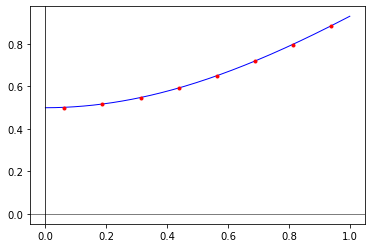

In [20]:
import scipy
from scipy.special import erf

figure(2)
clf()

def u_true(x):
    return (sqrt(pi)*x*erf(x) + exp(-x*x))/2     

xf = linspace(a,b,128)
plot(xf,u_true(xf),'b-',lw=1,label='True solution');

plot(x,u,'ro',ms=3,label='Computed solution');

kwargs = {'color' : 'k', 'lw' : 0.5, 'ls' : '-'}
axhline(**kwargs)
axvline(**kwargs)
axvline(**kwargs);

### (prob2) Convergence

You can use these convergence results below to verify your results. 

        Serial results (cell-centered)
        a=0.000000 b=1.000000
        Left  : bc_types.NEUMANN
        Right : bc_types.DIRICHLET

            8   1.5379e-03        8      ---
           16   3.8517e-04       16   3.9928   1.9974
           32   9.6335e-05       32   3.9982   1.9993
           64   2.4086e-05       64   3.9995   1.9998
          128   6.0218e-06      128   3.9999   2.0000
          256   1.5055e-06      256   4.0000   2.0000
          512   3.7636e-07      512   4.0000   2.0000
         1024   9.4091e-08     1025   4.0000   2.0000

        Test completed.

In [21]:
import subprocess
import shlex

print("Serial results (cell-centered)")
print(f"{a=:f} {b=:f}")
print(f"Left  : {bc_type[0]:s}")
print(f"Right : {bc_type[1]:s}")
print("")

bc_str = ' '.join([f"{bc_type[i].value:d}" for i in range(2)])
shell_cmd = './cg_serial_02 {N:d} {bc_str:s}'.format


M = 8
N0 = 8
Nv = N0*2**arange(M)

dt1 = dtype([('err',float64),('itcount',int32)])

err = empty(M)
for i in range(M):
    N = Nv[i]
    cmd = shell_cmd(N=N,bc_str=bc_str)
    arg_list = shlex.split(cmd) 

    # Run output
    output=subprocess.run(arg_list,capture_output=True)
    if rc := output.returncode != 0:
        print(f"Return code = {rc:d} : Invalid boundary condition choice")
        break
        
    fout = open("err_02.dat","rb")
    err_pde,itcount = fromfile(fout,dtype=dt1, count=1)[0]
    fout.close()
        
    err[i] = err_pde
    
    print(f"{N:5d} {err_pde:12.4e} {itcount:8d} ",end="")    
    if i > 0:
        rate2 = (err[i-1]/err[i])
        print(f"{rate2:8.4f} {log2(rate2):8.4f}")
    else:
        print("{:>8s}".format("---"))
        
print("")        
print("Test completed.")

Serial results (cell-centered)
a=0.000000 b=1.000000
Left  : bc_types.NEUMANN
Right : bc_types.DIRICHLET

    8   1.5379e-03        8      ---
   16   3.8517e-04       16   3.9928   1.9974
   32   9.6335e-05       32   3.9982   1.9993
   64   2.4086e-05       64   3.9995   1.9998
  128   6.0218e-06      128   3.9999   2.0000
  256   1.5055e-06      256   4.0000   2.0000
  512   3.7636e-07      512   4.0000   2.0000
 1024   9.4091e-08     1024   4.0000   2.0000

Test completed.


In [22]:
# Leave blank


### Discussion

The cell-centered mesh was relatively easier to implement because the symmetry of the matrix is preserved, and I did not get to worry about the array sizes for the different boundary conditions. The cell-centered code is relatively shorter too.

<a id="prob2"></a>

<hr style="border:2px coral solid"></hr>

## Problem #3 :  Parallel

<hr style="border:2px coral solid"></hr>

Implement either the node-centered or the cell-centered solver in parallel.  

### To Do

* Choose either your code from Problem #1 or Problem #2 to parallelize. Explain why you made the choice you did. 

* Modify your code to include parallel communication between solution values on different ranks. 

Report your convergence results for $N=512$ on four processors. 


### Tips

* Use `MPI_Sendrecv` for exchanging data at the processor boundaries.

* For reduction steps, take advantage of the fact that you can do a reduction for more than one value in a single reduction step.


In [23]:
%%file cg_parallel_03.c

#include <stdio.h>
#include <stdlib.h>
#include <math.h>

#include <mpi.h>

#include "hmwk06_all_1d.c"

int bc_type[2];

void matvec(int N, double *u, double *L)
{
    int rank, nprocs;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);    
    MPI_Comm_size(MPI_COMM_WORLD,&nprocs);
    int i1 = 0, i2 = N;   
    
    u[-1] = (rank == 0 && bc_type[LEFT] == NEUMANN)? u[0]:-u[0];
    u[N] = (rank == nprocs -1 && bc_type[RIGHT] == NEUMANN)? u[N-1]: -u[N-1]; 
    
    if (rank > 0)
    {
        int tag = 0;
        int sender = rank - 1;
        MPI_Sendrecv(&u[0], 1, MPI_DOUBLE, sender, tag, &u[-1], 1, MPI_DOUBLE, sender, tag, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
        

    }

    if (rank < nprocs - 1)
    {
        int tag = 0;
        int dest = rank + 1;
        MPI_Sendrecv(&u[N-1], 1, MPI_DOUBLE, dest, tag, &u[N], 1, MPI_DOUBLE, dest, tag, MPI_COMM_WORLD, MPI_STATUS_IGNORE);

    }

    
    for(int i = i1; i < i2; i++) 
    {
        
            L[i] = u[i-1] - 2*u[i] + u[i+1];
    }

}

    
    
void cg(int N, double *F, double *u, double tol, int kmax, int prt,int *itcount)
{
    
    int rank, nprocs;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &nprocs);

    // # TODO : implement parallel CG
    int i1 =0, i2=N; 

    
    double *uk = allocate_1d(N,0);
    double *pk = allocate_1d(N,1);    
    double *rk = allocate_1d(N,0);
    double *Apk = allocate_1d(N,0);
    double *rkp1 = allocate_1d(N,0);
    
    
    for(int i = i1; i < i2; i++)
    {
        uk[i] = 0;
        rk[i] = F[i];
        pk[i] = rk[i];    // # Start with uk = 0 --> r = b - Au = b            
    }
    
    
    for(int i = i1; i < i2; i++)
    {
        uk[i] = 0;
        rk[i] = F[i];
        pk[i] = rk[i];    // # Start with uk = 0 --> r = b - Au = b            
    }
    
    for(int k = 0; k <kmax; k++)
    {        
        matvec(N,pk,Apk);
        
        double rTr = 0;
        double pTAp = 0;
        for(int i = i1; i < i2; i++)
        {
            rTr += rk[i]*rk[i];
            pTAp += pk[i]*Apk[i];
        }
        
        double rTr_global;
        double pTAp_global;
        
        
        MPI_Allreduce(&rTr, &rTr_global, 1, MPI_DOUBLE, MPI_SUM, MPI_COMM_WORLD);
        MPI_Allreduce(&pTAp, &pTAp_global, 1, MPI_DOUBLE, MPI_SUM, MPI_COMM_WORLD);
       
      
        double alpha = rTr_global/pTAp_global;
        
        double rpTrp = 0;
        double max_res = 0;
        for(int i = i1; i < i2; i++)
        {
            uk[i] = uk[i] + alpha*pk[i];
            rkp1[i] = rk[i] - alpha*Apk[i];
            rpTrp += rkp1[i]*rkp1[i];
            max_res = fmax(fabs(rkp1[i]),max_res);
        }
   
        double rpTrp_global;
        MPI_Allreduce(&rpTrp, &rpTrp_global, 1, MPI_DOUBLE, MPI_SUM, MPI_COMM_WORLD);
        double beta = rpTrp_global/rTr_global;
        
        *itcount = k+1;
        double MAXERROR;
        MPI_Allreduce(&max_res, &MAXERROR, 1, MPI_DOUBLE, MPI_MAX, MPI_COMM_WORLD);
        if (prt)
            printf("%5d %12.4e\n",*itcount,MAXERROR);
        
        if (MAXERROR < tol)
        
            break;
                
        
        // # Update search directions
        for(int i = i1; i < i2; i++)
            pk[i] = rkp1[i] + beta*pk[i];
                
        // # Update residuals
        for(int i = i1; i < i2; i++)
            rk[i] = rkp1[i];  
    }
    for(int i = i1; i < i2; i++)
        u[i] = uk[i];     
    
    free_1d(&uk,0);
    free_1d(&pk,1);
    free_1d(&rk,0);
    free_1d(&Apk,0);
    free_1d(&rkp1,0);
        
}
    
    


int main(int argc, char** argv)
{
    MPI_Init(&argc, &argv);

    int rank,nprocs;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);    
    MPI_Comm_size(MPI_COMM_WORLD,&nprocs);

    int N;
    int count;
    int code = parse_input(argc,argv,&N,&bc_type[0]);
    if (code > 0)
        exit(1);
    
    // # Domain
    double a = 0.0, b = 1.0;
    
    // # Local values
    int N_local = N/nprocs;
    double h = (b - a)/N;
    double a_local = a + rank * N_local * h;
   
    double b_local = a_local + N_local * h;
    
   
    // # Numerical parameters
    int kmax;
    if (bc_type[LEFT] == NEUMANN && bc_type[RIGHT] == NEUMANN)
    {
        kmax = 30;
        printf("All Neumann boundary conditions may not converge. " \
               "Value of kmax is set to %d.\n\n",kmax);
    }
    else
        kmax = 10000;
        
    double tol = 1e-12;
    int prt = 0;
    
    // # TODO : Implemement parallel version of code in Problem 1 or Problem 2, above. 
    
    // # Set up right hand side F
    double h_local = (b_local - a_local)/N_local;
    
  
    
    // # Arrays    
    double *u_local = allocate_1d(N_local,1);
    double *F_local = allocate_1d(N_local,0);
    double *x_local = allocate_1d(N_local,0);
    
    // # Initialization
    for(int i = 0; i < N_local; i++)
    {
       x_local[i] = a_local + (i+0.5)*h_local;
       F_local[i] = h_local*h_local*upp_true(x_local[i]);       
    }

     
    
    if (rank == 0 && bc_type[LEFT] == DIRICHLET)
        F_local[0] -=2*u_true(a);
        
    
    if (rank == 0 && bc_type[LEFT] == NEUMANN)
    {
        F_local[0] -=h_local*up_true(LEFT,a);
    }
        
    
    if (rank == nprocs - 1 && bc_type[RIGHT] == DIRICHLET)
        F_local[N_local-1] -=2*u_true(b); 
        
     if (rank == nprocs -1 && bc_type[RIGHT] == NEUMANN)
        F_local[N_local-1] -=h_local*up_true(RIGHT,b);
 
     //# Compute the solution using CG
    cg(N_local,F_local,u_local,tol,kmax,prt, &count);
    
    double MAXERR = 0.0;
    double max_err = 0;
    for(int i = 0; i < N_local; i++)
    {
      x_local[i] = a_local + (i+0.5)*h_local;
      max_err = fmax(fabs(u_true(x_local[i]) - u_local[i]),max_err);
    }
        
    
    
    MPI_Reduce(&max_err, &MAXERR, 1, MPI_DOUBLE, MPI_MAX, 0, MPI_COMM_WORLD); 
    
    if (rank == 0)
    {
    FILE* fout = fopen("err_03.dat","wb");   
    fwrite(&MAXERR,sizeof(double),1,fout);
    fwrite(&count,sizeof(int),1,fout);
    fclose(fout);   
    printf("itcount = %d\n",count);
    printf("\n");
    printf("N = %d\n",N);
     printf("Error (pde)     : %12.4e\n",MAXERR);
    }
              
    double *U = NULL, *x = NULL;
    if (rank == 0)
    {
        U = allocate_1d(N,0);
        x = allocate_1d(N,0);
    }
    MPI_Gather(&u_local[0], N_local, MPI_DOUBLE, U, N_local, MPI_DOUBLE, 0, MPI_COMM_WORLD);
    MPI_Gather(x_local, N_local, MPI_DOUBLE, x, N_local, MPI_DOUBLE, 0, MPI_COMM_WORLD);

    if (rank == 0)
    {
        FILE *fout = fopen("cg_03.dat","w");
        fwrite(&N,sizeof(int),1,fout);
        fwrite(bc_type,sizeof(int),2,fout);
        fwrite(&a,sizeof(double),1,fout);
        fwrite(&b,sizeof(double),1,fout);
        fwrite(x,sizeof(double),N, fout);
        fwrite(U,sizeof(double),N, fout);
        fclose(fout);
    }
    free_1d(&F_local,0);
    free_1d(&u_local,1);
    free_1d(&x_local,0);
    free_1d(&U,0);
    free_1d(&x,0);
    
    MPI_Finalize();


    
    return 0;
}    

Overwriting cg_parallel_03.c


### Run code and get output (parallel)
   

In [24]:
%%bash

rm -rf cg_03.dat

rm -rf cg_parallel_03.o cg_parallel_03

mpicc -o cg_parallel_03 cg_parallel_03.c

# cg_serial <N> <bc_type>
 mpirun -n 2 ./cg_parallel_03 8 1 0

itcount = 8

N = 8
Error (pde)     :   1.5379e-03


In [25]:
import os

    

fout = open("cg_03.dat","rb")
N, = fromfile(fout,dtype=int32,count=1)
fout.close()

stats = os.stat("cg_03.dat")
print(f"File size          : {stats.st_size:d} bytes")

esize = 3*4 + 8*(2 + 2*N)
print(f"Expected file size : {esize:d} bytes")

File size          : 156 bytes
Expected file size : 156 bytes


In [26]:
dt = dtype([('N',int32),\
            ('bc_type', int32,2), \
            ('a',float64), \
            ('b',float64),\
            ('x',float64,N), \
            ('u',float64,N)])


  

fout = open("cg_03.dat","rb")
N,bc,a,b,x,u = fromfile(fout,dtype=dt, count=1)[0]
fout.close()

bc_types = Enum('bc_types', ['DIRICHLET', 'NEUMANN'], start = 0)
bc_type = [bc_types(bc[i]) for i in [0,1]]

print(f"{N=:d} {a=:f} {b=:f}")
print(f"Left  : {bc_type[0]:s}")
print(f"Right : {bc_type[1]:s}")

N=8 a=0.000000 b=1.000000
Left  : bc_types.NEUMANN
Right : bc_types.DIRICHLET


### (prob3) Plot the solution

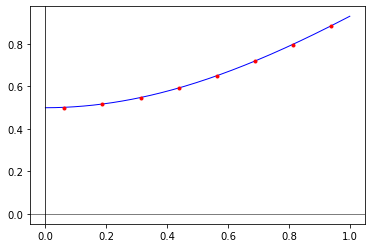

In [27]:
import scipy
from scipy.special import erf

figure(2)
clf()

def u_true(x):
    return (sqrt(pi)*x*erf(x) + exp(-x*x))/2     

xf = linspace(a,b,128)
plot(xf,u_true(xf),'b-',lw=1,label='True solution');

plot(x,u,'ro',ms=3,label='Computed solution');

kwargs = {'color' : 'k', 'lw' : 0.5, 'ls' : '-'}
axhline(**kwargs)
axvline(**kwargs)
axvline(**kwargs);

### (prob3) Convergence

You can use the results from the serial codes above to verify your results. 

    Serial results (node-centered mesh)
    a=0.000000 b=1.000000
    Left  : bc_types.NEUMANN
    Right : bc_types.DIRICHLET

        8   8.2587e-04        8      ---
       16   2.0594e-04       16   4.0102   2.0037
       32   5.1453e-05       32   4.0025   2.0009
       64   1.2861e-05       64   4.0006   2.0002
      128   3.2152e-06      128   4.0002   2.0001
      256   8.0379e-07      256   4.0000   2.0000
      512   2.0095e-07      512   4.0000   2.0000
     1024   5.0237e-08     1024   4.0000   2.0000    
     
    Test completed.     

    Serial results (cell-centered)
    a=0.000000 b=1.000000
    Left  : bc_types.NEUMANN
    Right : bc_types.DIRICHLET

        8   1.5379e-03        8      ---
       16   3.8517e-04       16   3.9928   1.9974
       32   9.6335e-05       32   3.9982   1.9993
       64   2.4086e-05       64   3.9995   1.9998
      128   6.0218e-06      128   3.9999   2.0000
      256   1.5055e-06      256   4.0000   2.0000
      512   3.7636e-07      512   4.0000   2.0000
     1024   9.4091e-08     1024   4.0000   2.0000

    Test completed.


#### Note
The convergence test below may not always run to completion. If you get a message

       No data was read ...
       
you can try running the test again.  This error is likely happening because the Python subprocess completes before the MPI processes have written out data to the file read by this test. 

In [28]:
import subprocess
import shlex

nprocs = 4

   

print(f"{a=:f} {b=:f}")
print(f"{nprocs=:d}")
print(f"Left  : {bc_type[0]:s}")
print(f"Right : {bc_type[1]:s}")
print("")


bc_str = ' '.join([f"{bc_type[i].value:d}" for i in range(2)])
shell_cmd = 'mpirun -n {P:d} ./cg_parallel_03 {N:d} {bc_str:s}'.format

M = 8
N0 = 8
Nv = N0*2**arange(M)

dt1 = dtype([('err',float64),('itcount',int32)])

err = empty(M)
for i in range(M):
    N = Nv[i]
    cmd = shell_cmd(P=nprocs,N=N,bc_str=bc_str)
    arg_list = shlex.split(cmd) 

    # Run output
    output = subprocess.run(arg_list,capture_output=True,timeout=1)
    if rc := output.returncode != 0:
        print(f"Return code = {rc:d} : Invalid boundary condition choice")
        break
        
    fout = open("err_03.dat","rb")    
    data = fromfile(fout,dtype=dt1, count=1)
    fout.close()

    assert len(data) > 0, "No data was read ..."
                
    err_pde,itcount = data[0]
        
    err[i] = err_pde
    
    print(f"{N:5d} {err_pde:12.4e} {itcount:8d} ",end="")    
    if i > 0:
        rate2 = (err[i-1]/err[i])
        print(f"{rate2:8.4f} {log2(rate2):8.4f}")
    else:
        print("{:>8s}".format("---"))
        
print("")
print("Test completed.")        

a=0.000000 b=1.000000
nprocs=4
Left  : bc_types.NEUMANN
Right : bc_types.DIRICHLET

    8   1.5379e-03        8      ---
   16   3.8517e-04       16   3.9928   1.9974
   32   9.6335e-05       32   3.9982   1.9993
   64   2.4086e-05       64   3.9995   1.9998
  128   6.0218e-06      128   3.9999   2.0000
  256   1.5055e-06      256   4.0000   2.0000
  512   3.7636e-07      512   4.0000   2.0000
 1024   9.4091e-08     1024   4.0000   2.0000

Test completed.


<a id="prob4"></a>

<hr style="border:2px solid coral"></hr>

## Problem 4 : Cell-Centered (2d)

<hr style="border:2px solid coral"></hr>



In [29]:
%%file hmwk06_all_2d.c

#include <stdio.h>
#include <stdlib.h>
#include <math.h>

enum
{
    DIRICHLET=0,
    NEUMANN
};

enum
{
    LEFT=0,
    RIGHT,
    BOTTOM,
    TOP
};

int bc_type[4];

double* allocate_1d(int n, int m)
{
    double *mem = (double*) malloc((n + 2*m)*sizeof(double));
    return mem+m;
}

void free_1d(double **x, int m)
{
    free(*x-m);
    *x = NULL;
}

double** allocate_2d(int n, int m, int mbc)
{
    int rows = n + 2*mbc;
    int cols = m + 2*mbc; 

    double   *qmem = malloc(rows*cols*sizeof(double));
    double **qrows = malloc(rows*sizeof(double*));

    for(int i = 0; i < rows; i++)
    {
        qrows[i] = &qmem[cols*i + mbc];
    }    
    return &qrows[mbc];
}

void free_2d(double ***q,int mbc)
{
    free(&(*q)[-mbc][-mbc]);
    free(&(*q)[-mbc]);
    *q = NULL;
}

double u_true(double x,double y)
{
    return sin(2*x)*sin(2*y);
}

double ux_true(double x, double y)
{
    return 2*cos(2*x)*sin(2*y);
}

double uxx_true(double x, double y)
{
    return -4*u_true(x,y);
}

double uy_true(double x, double y)
{
    return 2*sin(2*x)*cos(2*y);
}

double uyy_true(double x, double y)
{
    return -4*u_true(x,y);
}

double un_true(int iside,double x,double y)
{
    double un;
    if (iside == LEFT)
        un = -ux_true(x,y);
    
    else if (iside == RIGHT)
        un = ux_true(x,y);
    
    else if (iside == BOTTOM)
        un = -uy_true(x,y);
    
    else if (iside == TOP)
        un = uy_true(x,y);

    return un;
}

double upp_true(double x,double y)
{
    return uxx_true(x,y) + uyy_true(x,y);
}

Overwriting hmwk06_all_2d.c


In [30]:
%%file cg_serial_04.c

#include <stdio.h>
#include <stdlib.h>
#include <math.h>

#include "hmwk06_all_2d.c"



void matvec(int N, double **u, double **L)
{
    
    
    for(int j = 0; j < N; j++)
    {
        if (bc_type[LEFT] == DIRICHLET)
            u[-1][j] = -u[0][j];
        else
            u[-1][j] = u[0][j];
        if (bc_type[RIGHT] == DIRICHLET)
            u[N][j] = -u[N-1][j];
        else
            u[N][j] = u[N-1][j];
    }
    
    for(int j = 0; j < N; j++)
    {
        if (bc_type[BOTTOM] == DIRICHLET)
            u[j][-1] = -u[j][0];
        else
            u[j][-1] = u[j][0];
        
        if (bc_type[TOP] == DIRICHLET)
            u[j][N] = -u[j][N-1];
        else
            u[j][N] = u[j][N-1];
    }
    
    for(int i = 0; i < N; i++)
    {
        for(int j = 0; j <N; j++)
        {
            L[i][j] = (u[i-1][j] + u[i+1][j] + u[i][j-1] + u[i][j+1]- 4*u[i][j]) ;
        }
    }
    
    
}



int cg(int N, double **F, double **u, double tol, int kmax, int prt)
{
    // # TODO : Implement at 2d CG solver

    int itcount = 0;
    int i1 =0;
    int i2 = N;
    
    double **uk = allocate_2d(N,N,0);
    double **pk = allocate_2d(N,N,1);    
    double **rk = allocate_2d(N,N,0);
    double **Apk = allocate_2d(N,N,0);
    double **rkp1 = allocate_2d(N,N,0);
    
  
    for(int i = i1; i < i2; i++)
     {
      for(int j = i1; j < i2; j++)
    {
        uk[i][j] = 0;
        rk[i][j] = F[i][j];
        pk[i][j] = rk[i][j];    // # Start with uk = 0 --> r = b - Au = b            
    }   
     }   
   
   
 
    for(int k = 0; k < kmax; k++)
    {
        
        matvec(N, pk, Apk);
        
        double rTr = 0;
        double pTAp = 0;
        for(int i = i1; i < i2; i++)
        {
            for (int j = i1; j<i2;j++)
            {
            rTr += rk[i][j]*rk[i][j];
            pTAp += pk[i][j]*Apk[i][j]; 
            }
            
        }
         
        
        
        double alpha = rTr/pTAp;
        
        double rpTrp = 0;
        double max_res = 0;
        
        for(int i = i1; i < i2; i++)
        {
            for(int j = i1; j < i2; j++)
            {
                    uk[i][j] = uk[i][j] + alpha*pk[i][j];
                rkp1[i][j] = rk[i][j] - alpha*Apk[i][j];
                rpTrp += rkp1[i][j]*rkp1[i][j];
                max_res = fmax(fabs(rkp1[i][j]),max_res);
            }
        }
    
        
        itcount = k+1;
        
        //printf("%d error = %12.4e\n",k, max_res); 
        if (max_res < tol)
            break;
        
        
        double beta = rpTrp/rTr;
        
        for(int i = i1; i < i2; i++)
        {
         for(int j = i1; j < i2; j++)
            {
              pk[i][j] = rkp1[i][j] + beta*pk[i][j];   
            }
                  
        }
        
       
        for(int i = i1; i < i2; i++)
        {
         for (int j =i1; j<i2;j++)
               rk[i][j] = rkp1[i][j];  
        }
           
        rTr = rpTrp;
        
    }
    
    for(int i = i1; i < i2; i++)
    {
      for(int j = i1; j < i2; j++)
        {
          u[i][j] = uk[i][j];    
        }
             
    }
    
    
    
    free_2d(&uk,0);
    free_2d(&pk,1);
    free_2d(&rk,0);
    free_2d(&rkp1,0);
    free_2d(&Apk,0);

    
    
    return itcount;
    
}

int main(int argc, char** argv)
{

    int N;
    if (argc != 6)
    {
        N = 64;
        for(int i = 0; i < 4; i++)
            bc_type[i] = DIRICHLET;
    }        
    else
    {
        N = atoi(argv[1]);    
        for(int i = 0; i < 4; i++)
            bc_type[i] = atoi(argv[2+i]);
    }    
    
    // # Domain
    double a = 0, b = 2*M_PI;
    
    // # Numerical parameters
    double tol = 1e-13;
    int kmax = 10000;    
    int prt = 0;

    // # TODO : Implement a 2d solver using either cell-centered or node-centered. 
    
    double h = (b-a)/N;
    
    // # Arrays    
    double **u = allocate_2d(N,N,1);
    double **F = allocate_2d(N,N,0);
    double *x = allocate_1d(N,0);
    double *y = allocate_1d(N,0);
   
    // # Initialization
    for(int i = 0; i < N; i++)
    {
        x[i] = a + (i+0.5)*h;
        
        for(int j = 0; j < N; j++)
        {
          y[j] = a + (j+0.5)*h;  
            F[i][j] = pow(h,2)*upp_true(x[i],y[j]);
        }
    }
    
     
    
    //# Apply BCs
    
    
     if (bc_type[LEFT] == DIRICHLET)
    {
         for(int i = 0; i < N; i++)
        {
             F[0][i] -=2* u_true(a,y[i]);
        }
           
    }
    
    if (bc_type[LEFT] == NEUMANN)
    {
         for(int i = 0; i < N; i++)
        {
             F[0][i] -=h*un_true(LEFT,a, y[i]);
        }
           
    }
    
    if (bc_type[RIGHT] == DIRICHLET)
    {
        for (int i = 0; i< N; i++)
        {
            F[N-1][i] -=2*u_true(b,y[i]);
        }
    }
    
    if (bc_type[RIGHT] == NEUMANN)
    {
        for (int i = 0; i< N; i++)
        {
            F[N-1][i] -=h*un_true(RIGHT,b, y[i]);
        }
    }

    if (bc_type[TOP] == DIRICHLET)
    {
        for (int i = 0; i< N; i++)
        {
            F[i][N-1] -=2*u_true(b,x[i]);
        }
    }
        
    if (bc_type[TOP] == NEUMANN)
    {
        for (int i = 0; i< N; i++)
        {
            F[i][N-1] -=h*un_true(TOP,b, x[i]);
        }
    }
    
    if (bc_type[BOTTOM] == DIRICHLET)
    {
        for (int i = 0; i< N; i++)
        {
            F[i][0] -=2*u_true(a,x[i]);
        }
    }
        
    if (bc_type[BOTTOM] == NEUMANN)
    {
        for (int i = 0; i< N; i++)
        {
            F[i][0] -=h*un_true(BOTTOM,a, x[i]);
        }
    }
    
    // # Compute the solution using conjugate Gradient method
    int itcount = cg(N,F,u,tol,kmax,prt);
    
    double max_err = 0;
    for(int i = 0; i < N; i++)
    {
        for(int j = 0; j<N; j++)
        {
            max_err = fmax(fabs(u_true(x[i],y[j]) - u[i][j]),max_err);
            
        }
      
         
    }
 
     printf("max error = %12.4e\n", max_err); 
     
     FILE* fout = fopen("err_04.dat","w");   
     fwrite(&max_err,sizeof(double),1,fout);
     fwrite(&itcount,sizeof(int),1,fout);
     fclose(fout);
    
     
    FILE *file = fopen("cg_04.dat","wb");      
    fwrite(&N,sizeof(int),1,file);
    fwrite(bc_type,sizeof(int),4,file);
    fwrite(&a,sizeof(double),1,file);
    fwrite(&b,sizeof(double),1,file);
    fwrite(x,sizeof(double),N, file); 
    fwrite(y,sizeof(double),N, file); 
    
    for(int i = 0; i < N; i++)
        fwrite(u[i],sizeof(double),N, file); 
    fclose(file);
    
    
    free_2d(&u,1);
    free_2d(&F,0);
    free_1d(&x,0);
    free_1d(&y,0);

    
    return 0;
}    

Overwriting cg_serial_04.c


### Run code and get output (serial)

In [31]:
%%bash

rm -rf cg_04.dat

rm -rf cg_serial_04.o cg_serial_04

gcc -o cg_serial_04 cg_serial_04.c

# cg_serial <N> <bc_type>
 ./cg_serial_04 64 1 1 0 0

max error =   3.5574e-03


In [32]:
import os


fout = open("cg_04.dat","rb")
N, = fromfile(fout,dtype=int32,count=1)
fout.close()

stats = os.stat("cg_04.dat")
esize = 5*4 + 8*(2 + 2*N + N**2)
print(f"File size          : {stats.st_size:d} bytes ({esize/1024:.2f} kB)")


print(f"Expected file size : {esize:d} bytes")

File size          : 33828 bytes (33.04 kB)
Expected file size : 33828 bytes


In [33]:
dt = dtype([('N',int32),\
            ('bc_type',int32,4), \
            ('a',float64), \
            ('b',float64),\
            ('x',float64,N), \
            ('y',float64,N), \
            ('u',float64,N*N)])



fout = open("cg_04.dat","rb")
N,bc,a,b,x,y,u = fromfile(fout,dtype=dt, count=1)[0]
fout.close()

bc_types = Enum('bc_types', ['DIRICHLET', 'NEUMANN'], start = 0)
bc_type = [bc_types(bc[i]) for i in range(4)]

print(f"{N=:d} {a=:f} {b=:f}")
print(f"Left   : {bc_type[0]:s}")
print(f"Right  : {bc_type[1]:s}")
print(f"Bottom : {bc_type[2]:s}")
print(f"Top    : {bc_type[3]:s}")

N=64 a=0.000000 b=6.283185
Left   : bc_types.NEUMANN
Right  : bc_types.NEUMANN
Bottom : bc_types.DIRICHLET
Top    : bc_types.DIRICHLET


### Plot the solution (serial)

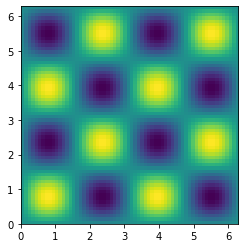

In [34]:
figure(4)
clf()



u = reshape(u,(N,N))

imshow(u,extent=[a,b,a,b],origin='lower');

### Convergence (2d)

In [35]:
import subprocess
import shlex

#assert 1==0, "Code not yet implemented"

print(f"{a=:f} {b=:f}")
print(f"Left   : {bc_type[0]:s}")
print(f"Right  : {bc_type[1]:s}")
print(f"Bottom : {bc_type[2]:s}")
print(f"Top    : {bc_type[3]:s}")
print("")

# Run command
bc_str = ' '.join([f"{bc_type[i].value:d}" for i in range(4)])
shell_cmd = './cg_serial_04 {N:d} {bc_str:s}'.format

M = 8
N0 = 8
Nv = N0*2**arange(M)

dt1 = dtype([('err',float64),('itcount',int32)])

err = empty(M)
for i in range(M):
    N = Nv[i]
    cmd = shell_cmd(N=N,bc_str=bc_str)
    arg_list = shlex.split(cmd) 

    # Run output
    output=subprocess.run(arg_list,capture_output=True)
    if (rc := output.returncode) != 0:
        print(f"Return code = {rc:d} : Invalid boundary condition choice")
        break
        
    fout = open("err_04.dat","rb")
    err_pde,itcount = fromfile(fout,dtype=dt1, count=1)[0]
    fout.close()
        
    err[i] = err_pde
    
    print(f"{N:5d} {err_pde:12.4e} {itcount:8d} ",end="")    
    if i > 0:
        rate2 = (err[i-1]/err[i])
        print(f"{rate2:8.4f} {log2(rate2):8.4f}")
    else:
        print("{:>8s}".format("---"))

print("")
print('Done.')        

a=0.000000 b=6.283185
Left   : bc_types.NEUMANN
Right  : bc_types.NEUMANN
Bottom : bc_types.DIRICHLET
Top    : bc_types.DIRICHLET

    8   1.6186e-01        4      ---
   16   5.3345e-02        8   3.0342   1.6013
   32   1.4098e-02       20   3.7839   1.9199
   64   3.5574e-03       46   3.9630   1.9866
  128   8.9071e-04       96   3.9939   1.9978
  256   2.2285e-04      191   3.9969   1.9989
  512   5.5718e-05      377   3.9996   1.9999
 1024   1.3930e-05      745   3.9998   1.9999

Done.
